# Environment Setup

Push a Nvidia repo to your artifact repository - (create a new repo if not available)

### Further instructions on how to build a Merlin container can be found [here](https://github.com/jswortz/merlin-gcp)

Guide
1. In an notebook instance run from a terminal `git clone https://github.com/jswortz/merlin-gcp`
2. Run the notebook - this will build a merlin tensorflow image. You can change the base images from NVidia if you choose - this was tested from the version in the repo
3. This will build a container image and save it to artifact registry repository. You may need to enable the artifact repository service
4. Create a new custom workbench by clicking "New Notebook" > "Customize"

<img src="img/custom_workbench.png" width="500"/>

5. To get to the screen for artifact repository. First select "Advanced" then name, select region, then go to "Environment"

<img src="img/workbench-environment.png" width="500"/>

6. Select the your repo and respective image

<img src="img/image.png" width="500"/>

7. Finally, if you already followed the instructions in notebook 02 setup - make sure the new workbench network is in the VPC peered network used for matching engine

# Training with Merlin

## Spotify example

Our goal is to enable the architecture below with Vertex AI and the Merlin Models framework

![](img/arch.png)

## Goals

The goal of this notebook is to create a simple two tower model with Nvtablular and Merlin Models

1. Export data to Parquet for use in Nvtabular
2. Create a NVtabular workflow and fit it to the data
3. Save the fitted workflow to GCS (contains all dictionary lookups)
4. Transform the data into GPU-optimized features from the NVtabular workflow and save to gcs
5. Load the data again as a Merlin dataset using the workflow
6. Create a two tower model in a few lines of code
7. Train a two tower model
8. Save the model (for deployment in notebook 03)
9. Export the embeddings and save to gcs (for deployment to matching engine)

*Based heavily on [this](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb) NVIDIA resource


Data is loaded from BQ - to parquet using the job configuration below


Info on the data

* track_uri_seed counts: 2249561
* artist_uri_seed counts: 294110
* album_uri_seed counts: 730377

# Export Data From BigQuery to Parquet on GCS

In [1]:
PROJECT = 'hybrid-vertex'  # <--- TODO: CHANGE THIS
LOCATION = 'us-central1' 
# path = 'gs://two-tower-models' #TODO change to your model directory
BUCKET = 'gs://spotify-beam-v3'
DATASET_ID = 'mdp_eda_test'
TABLE = 'train_flatten_last_5'
TABLE_VALIDATION = 'train_flatten_valid_last_5'

from google.cloud import bigquery
client = bigquery.Client()

def export_bq_to_parquet(PROJECT, DATASET_ID, TABLE, LOCATION, prefix):
    destination_uri = f"{BUCKET}/{prefix}_data_parquet/*.snappy.parquet"
    dataset_ref = bigquery.DatasetReference(PROJECT, DATASET_ID)
    table_ref = dataset_ref.table(TABLE)
    job_config = bigquery.job.ExtractJobConfig()
    job_config.destination_format = bigquery.DestinationFormat.PARQUET
    extract_job = client.extract_table(
        table_ref,
        destination_uri,
        job_config=job_config,
        # Location must match that of the source table.
        location=LOCATION,
    )  # API request
    return(extract_job.result())  # Waits for job to complete.

### Export the data from Bigquery to Parquet

*Run only once*

In [2]:
# # training
# export_bq_to_parquet(PROJECT, DATASET_ID, TABLE, LOCATION, prefix='train')

# # validation
# export_bq_to_parquet(PROJECT, DATASET_ID, TABLE_VALIDATION, LOCATION, prefix='valid')

In [3]:
# ## We also need to extract the candidate dataset
# export_bq_to_parquet(PROJECT, DATASET_ID, 'candidates', LOCATION, prefix='candidates')

# Create a nvtabular workflow to preprocess the data

In [4]:
import os
import nvtabular as nvt
from time import time
import pandas as pd
# disable INFO and DEBUG logging everywhere
import logging
import time

logging.disable(logging.WARNING)

from nvtabular.ops import (
    Categorify,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
    ListSlice
)
import nvtabular.ops as ops

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
import tensorflow as tf

# for running this example on CPU, comment out the line below
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2022-10-13 15:01:07.942876: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-13 15:01:09.903204: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 15:01:11.216236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20480 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


### Create NVTabular Dataset
This will be our pre-processor to hash strings and other preprocessing

In [5]:
train = nvt.Dataset(f"{BUCKET}/train_data_parquet/*.snappy.parquet")
valid = nvt.Dataset(f"{BUCKET}/valid_data_parquet/*.snappy.parquet")

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


#### Define the NVTabular preprocessing graph

Nvtabular takes a tabular dataset and transforms the data into new Parquet files optimized for training. This is equivalent to running a string lookup in tensorflow, and has similar functionality as adpat when a workflow is used

The graph is defined as a set of nodes and a node is defined as follows:

``` 
NODE_NAME = LIST_OF_FEATURE_NAMES >> nvt.ops.* >> [NEXT_STEP] >> Tag
```

Nvt has many ops - one of the most notable is `Categorify` as it is flexible and converts high cardnality text features to indicies

Tags are used as a means to label the schema in the metadata and serves as a label for merlin models to interpret for conumption (e.g. which features belong to the query tower and candidate tower have different tags). You will see the tags in the schema in examples below

In [6]:
item_id = ["track_uri_can"] >> Categorify(dtype="int32") >> TagAsItemID() 
playlist_id = ["pid"] >> Categorify(dtype="int32") >> TagAsUserID() 


item_features_cat = ['artist_name_can',
        'track_name_can',
        'artist_genres_can',
    ]

item_features_cont = [
        'duration_ms_can',
        'track_pop_can',
        'artist_pop_can',
        'artist_followers_can',
    ]

playlist_features_cat = [
        'description_pl',
        'name',
        'collaborative',
    ]

playlist_features_cont = [
        'duration_ms_seed_pl',
        'n_songs_pl',
        'num_artists_pl',
        'num_albums_pl',
    ]

#subset of features to be tagged
seq_feats_cont = [
        'duration_ms_songs_pl',
        'artist_pop_pl',
        'artists_followers_pl',
        'track_pop_pl',
    ]

seq_feats_cat = [
        'artist_name_pl',
        'track_uri_pl',
        'track_name_pl',
        'album_name_pl',
        'artist_genres_pl',
        # 'pid_pos_id', 
        # 'pos_pl'
    ]

CAT = playlist_features_cat + item_features_cat
CONT = item_features_cont + playlist_features_cont

item_feature_cat_node = item_features_cat >> nvt.ops.FillMissing()>> Categorify(dtype="int32") >> TagAsItemFeatures()

item_feature_cont_node =  item_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsItemFeatures()

playlist_feature_cat_node = playlist_features_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> TagAsUserFeatures() 

playlist_feature_cont_node = playlist_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsUserFeatures()

playlist_feature_cat_seq_node = seq_feats_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> TagAsUserFeatures() 

playlist_feature_cont_seq_node = seq_feats_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsUserFeatures()

### Define a workflow
This is an easy step by adding all nodes that need to run in parallel. A graphviz visualizaiton of the graph is available below

In [7]:
# define a workflow
output = playlist_id + item_id \
+ item_feature_cat_node \
+ item_feature_cont_node \
+ playlist_feature_cat_node \
+ playlist_feature_cont_node \
+ playlist_feature_cont_seq_node \
+ playlist_feature_cat_seq_node 


workflow = nvt.Workflow(output)

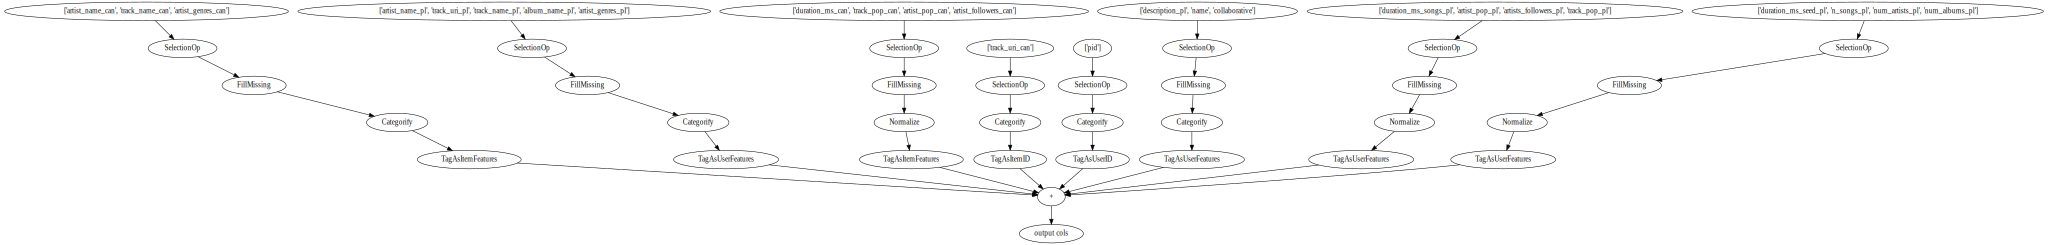

In [8]:
output.graph

### Before we transform the data, let's look at an original record
This loads the data into a dask pandas dataframe. `.to_ddf()` converts the dataset into a dask df

In [9]:
# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", None)

valid.to_ddf().head(1)

,name,collaborative,pid,modified_at,pid_pos_id,pos_can,artist_name_can,track_uri_can,album_uri_can,track_name_can,...,pos_pl,artist_name_pl,track_uri_pl,track_name_pl,duration_ms_songs_pl,album_name_pl,artist_pop_pl,artists_followers_pl,track_pop_pl,artist_genres_pl
0,Camp,false,498400,1472515200,498400-14,14,kinderlach,spotify:track:6wJHCHwzoP9reqwoJuFgQR,spotify:album:1RLivltCCWzZmeLUY0Siew,Just Do It,...,"[9, 10, 11, 12, 13]","[Gad Elbaz, Gad Elbaz, Omer Adam, Ari Goldwag, kinderlach]","[spotify:track:7j3BEtlXoPddHi7ateZyOJ, spotify:track:1UjR2tFIxm57eZuTyreuew, spotify:track:2bIFsmffovIlzqXeJGOB5X, spotify:track:0wmlo7aL8mlGRzLuC10rhb, spotify:track:0OjGNqjiQg06GcfvyKrYWI]","[Open Up, Hava Nagila, Mahapecha Shel SimcHa, Am Echad, Make It Happen]","[243466.0, 235320.0, 239128.0, 270778.0, 208023.0]","[L'Chaim, L'Chaim, Mode Ani, עם אחד (Am Echad), Kinderlach, Vol. 3]","[44.0, 44.0, 63.0, 34.0, 33.0]","[39988.0, 39988.0, 7.0, 0.0, 0.0]","[38.0, 37.0, 0.0, 35.0, 36.0]","['jewish pop', 'jewish pop', 'israeli mediterranean', 'israeli pop', 'mizrahi', 'jewish pop', 'jewish pop']"


### Now set the output buckets for the validation and training

In [10]:
output_path = os.path.join(BUCKET, "merlin-processed")
output_train_dir = os.path.join(output_path, 'train/')
output_valid_dir = os.path.join(output_path, 'valid/')
output_workflow_dir = os.path.join(output_path, 'workflow/')


print(f"Train data dir: {output_train_dir}\nValid data dir: {output_valid_dir}")

Train data dir: gs://spotify-beam-v3/merlin-processed/train/
Valid data dir: gs://spotify-beam-v3/merlin-processed/valid/


## Load and preprocess training data back to Parquet GCS
helpful resources https://cloud.google.com/compute/docs/gpus/monitor-gpus

## Also, be sure to install `nvtop` the install script is in `utils/install_nvtop.sh`

## Fit Transform is called on the workflow to pass over the data
The categorical and continuous features must be specified. In this example shuffling is enabled so we only shuflle one time. You can size your output and experiment with number of output files - depending on your use case think of your GPU memory available with respective file sizes

## ** This can take some time (about an hour) but is a one-time save to gcs **

In [ ]:
%%time

time_preproc = 0
time_preproc_start = time()

workflow.fit_transform(train).to_parquet(output_path=output_train_dir, 
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT, 
                                         output_files = 100
                                         ) #preserve_files=True keeps the original file sharding


time_preproc += time()-time_preproc_start

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


### Saving to GCS is simple with GCS Fuse, which is already included in the if you built an image from [here](https://github.com/jswortz/merlin-gcp)

In [ ]:
#save the workflow to disk (GCS here via ) after it has been fit
workflow.save(os.path.join(output_workflow_dir,'2t-spotify-workflow'))

#locally for demo too
workflow.save('2t-spotify-workflow')

## Transform validation data using the same workflow

This works similarly to a sklearn object where you can fit then transform after

In [ ]:
%%time

time_preproc_start = time()
workflow.transform(valid).to_parquet(output_path=output_valid_dir, 
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files=10
                                         )


time_preproc += time()-time_preproc_start

In [ ]:
workflow.input_schema

### Examine some of the output data from nvtabular

The data is presented as a Dask Pandas DF - so the interface is very familiar if you know Pandas

Now the data has encoded the values of the strings with categorify, filled missing values, and normalized continuous variables. Now when you look at categorical data like `track_name_pl`, you will see the data represented as an integer, ready to quickly load to an embedding layer, as opposed to hashing each Epoch like when including stringlookups or hash functions in a tfrs model. This ensures the unven profile caused by cpu/gpu bottlnecks during lookup functions are processed just once and effeciently.

#### Example of NVTabular Gpu Consumption Pattern
A100 a1-high-gpu
![Example of Nvtop](img/nvtop.png)

Note that the lookup tables for the various categorified data can be found in the `categories/` folder of the workflow. You also will notice a link in the data schema (more on that below) to the files by each field - this is how you can do reverse lookups later

In [22]:
nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['track_name_pl'].head(3) 

0        [427, 150, 361, 2477, 2305]
1    [210, 6632, 2262, 131141, 6601]
2       [748, 564, 2439, 4421, 4480]
Name: track_name_pl, dtype: object

In [23]:
nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['artist_name_can'].head(10)

0      138
1      406
2      563
3    15241
4      616
5     1336
6      437
7     5209
8      113
9     1577
Name: artist_name_can, dtype: int32

### Total rows for `part_0.parquet`
Total rows x number of partitions (`output_files` in `workflow.to_parquet()`)

In [24]:
len(nvtdata)

606451

#### Quick view of the embedding dimensions
`(INPUT_CARDNALITY, EMB_DIM)`

In [25]:
embeddings = ops.get_embedding_sizes(workflow)
embeddings

({'pid': (984638, 512),
  'track_uri_can': (2183658, 512),
  'artist_name_can': (278452, 512),
  'track_name_can': (1435485, 512),
  'artist_genres_can': (38183, 512),
  'description_pl': (17909, 385),
  'name': (92266, 512),
  'collaborative': (3, 16)},
 {'artist_name_pl': (283353, 512),
  'track_uri_pl': (2231210, 512),
  'track_name_pl': (1464629, 512),
  'album_name_pl': (563481, 512),
  'artist_genres_pl': (38373, 512)})

In [26]:
print([embeddings[0][x] for x in item_feature_cat_node.output_columns.names])

[(278452, 512), (1435485, 512), (38183, 512)]


In [27]:
playlist_feature_cont_node.output_columns.names

['duration_ms_seed_pl', 'n_songs_pl', 'num_artists_pl', 'num_albums_pl']

# Load the processed data into a Merlin Dataset and Train a Two Tower Model

Now that data inspection is over, the workflow is saved and data is processed to the `output_path`

The above only needs to be run once as well - the workflow and transformed files can be directly loaded from gcs from now on

### Get the embedding dimensions from the workflow

In [11]:
# load back the workflow and schema
# spotify-builtin-2t/merlin-processed/workflow/2t-spotify-workflow
workflow = nvt.Workflow.load(os.path.join(BUCKET, "merlin-processed/workflow/2t-spotify-workflow"))
schema = workflow.output_schema
embeddings = ops.get_embedding_sizes(workflow)
embeddings

({'pid': (984638, 512),
  'track_uri_can': (2183658, 512),
  'artist_name_can': (278452, 512),
  'track_name_can': (1435485, 512),
  'artist_genres_can': (38183, 512),
  'description_pl': (17909, 385),
  'name': (92266, 512),
  'collaborative': (3, 16)},
 {'artist_name_pl': (283353, 512),
  'track_uri_pl': (2231210, 512),
  'track_name_pl': (1464629, 512),
  'album_name_pl': (563481, 512),
  'artist_genres_pl': (38373, 512)})

In [12]:
from merlin.models.utils.example_utils import workflow_fit_transform

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset as MerlinDataset

train = MerlinDataset(os.path.join(output_train_dir, "*.parquet"), schema=schema, part_size="500MB")
valid = MerlinDataset(os.path.join(output_valid_dir, "*.parquet"), schema=schema, part_size="500MB")

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


### Below shows how you can manipulate the data schema to select the fields for training

In [13]:
#removing sequence features for now to train the 2t model

all_but_continuous_ragged = CAT + CONT + seq_feats_cat # omitting playlist_features_cont, continuous sequences not supported yet
all_but_continuous_ragged
two_t_schema = schema.select_by_name(all_but_continuous_ragged + ['track_uri_can', 'pid'])


pd.DataFrame(two_t_schema)

,name,tags,properties,dtype,is_list,is_ragged
0,description_pl,"(Tags.CATEGORICAL, Tags.USER)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.description_pl.parquet', 'domain': {'min': 0, 'max': 17909, 'name': 'description_pl'}, 'embedding_sizes': {'cardinality': 17909, 'dimension': 385}}",int32,False,False
1,name,"(Tags.CATEGORICAL, Tags.USER)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.name.parquet', 'domain': {'min': 0, 'max': 92266, 'name': 'name'}, 'embedding_sizes': {'cardinality': 92266, 'dimension': 512}}",int32,False,False
2,collaborative,"(Tags.CATEGORICAL, Tags.USER)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.collaborative.parquet', 'domain': {'min': 0, 'max': 3, 'name': 'collaborative'}, 'embedding_sizes': {'cardinality': 3, 'dimension': 16}}",int32,False,False
3,artist_name_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_name_can.parquet', 'domain': {'min': 0, 'max': 278452, 'name': 'artist_name_can'}, 'embedding_sizes': {'cardinality': 278452, 'dimension': 512}}",int32,False,False
4,track_name_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.track_name_can.parquet', 'domain': {'min': 0, 'max': 1435485, 'name': 'track_name_can'}, 'embedding_sizes': {'cardinality': 1435485, 'dimension': 512}}",int32,False,False
5,artist_genres_can,"(Tags.CATEGORICAL, Tags.ITEM)","{'num_buckets': None, 'freq_threshold': 0, 'max_size': 0, 'start_index': 0, 'cat_path': './/categories/unique.artist_genres_can.parquet', 'domain': {'min': 0, 'max': 38183, 'name': 'artist_genres_can'}, 'embedding_sizes': {'cardinality': 38183, 'dimension': 512}}",int32,False,False
6,duration_ms_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
7,track_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
8,artist_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False
9,artist_followers_can,"(Tags.CONTINUOUS, Tags.ITEM)",{},float64,False,False


Direct quote from [here](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb)

### Negative sampling
Many datasets for recommender systems contain implicit feedback with logs of user interactions like clicks, add-to-cart, purchases, music listening events, rather than explicit ratings that reflects user preferences over items. To be able to learn from implicit feedback, we use the general (and naive) assumption that the interacted items are more relevant for the user than the non-interacted ones. In Merlin Models we provide some scalable negative sampling algorithms for the Item Retrieval Task. In particular, we use in this example the in-batch sampling algorithm which uses the items interacted by other users as negatives within the same mini-batch.

### Building the Model
Now, let's build our Two-Tower model. In a nutshell, we aggregate all user features to feed in user tower and feed the item features to the item tower. Then we compute the positive score by multiplying the user embedding with the item embedding and sample negative items (read more about negative sampling here and here), whose item embeddings are also multiplied by the user embedding. Then we apply the loss function on top of the positive and negative scores.

- Other model types can be found on the [Merlin Models API Documentation Page](https://nvidia-merlin.github.io/models/main/api.html#tensorflow-models)

In [14]:
# we will use this to track data in tensorboard
from google.cloud import aiplatform as vertex_ai

TB_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/tensorboards/7336372589079560192' #fqn - project number then tensorboard id
EXPERIMENT_NAME = f'spotify-merlin-train-full-data-v1'
RUN_NAME = f'run-{EXPERIMENT_NAME}-{time.strftime("%Y%m%d-%H%M%S")}'#be sure to think about run and experiment naming strategies so names don't collide
logs_dir = f'{output_path}/tb-logs/{EXPERIMENT_NAME}'

#helper function to get the tb-uploader command

def get_upload_logs_to_manged_tb_command():
    """
    Run this and copy/paste the command into terminal to have 
    upload the tensorboard logs from this machine to the managed tb instance
    """
    print(f"""Helper for copy/past TF log upload command:

    tb-gcp-uploader --tensorboard_resource_name={TB_RESOURCE_NAME} \
      --logdir={logs_dir} \
      --experiment_name={EXPERIMENT_NAME} --one_shot=False
    """)

get_upload_logs_to_manged_tb_command()

vertex_ai.init(experiment=EXPERIMENT_NAME)
vertex_ai.start_run(RUN_NAME, tensorboard=TB_RESOURCE_NAME)

layers = [256, 128]
LR = .0001
BS = 8192*2
epoch = 5

vertex_ai.log_params({"layers": str(layers), 
                      "learning_rate": LR,
                        "num_epochs": epoch,
                        "batch_size": BS,
                     })

tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=logs_dir,
        histogram_freq=1, 
        write_graph=True, 
        # profile_batch=(20,50) #run profiler on steps 20-40 - enable this line if you want to run profiler from the utils/ notebook
    )

model = mm.TwoTowerModel(
    two_t_schema,
    query_tower=mm.MLPBlock(layers, no_activation_last_layer=True),
    item_tower=mm.MLPBlock(layers, no_activation_last_layer=True),
    samplers=[mm.InBatchSampler()],
    embedding_options=mm.EmbeddingOptions(infer_embedding_sizes=True),
)

Helper for copy/past TF log upload command:

    tb-gcp-uploader --tensorboard_resource_name=projects/934903580331/locations/us-central1/tensorboards/7336372589079560192       --logdir=gs://spotify-beam-v3/merlin-processed/tb-logs/spotify-merlin-train-full-data-v1       --experiment_name=spotify-merlin-train-full-data-v1 --one_shot=False
    


Let's explain the parameters in the TwoTowerModel():

* no_activation_last_layer: when set True, no activation is used for top hidden layer. Learn more here.
* infer_embedding_sizes: when set True, automatically defines the embedding dimension from the feature cardinality in the schema

**Metrics:**

The following information retrieval metrics are used to compute the Top-10 accuracy of recommendation lists containing all items:

* **Normalized Discounted Cumulative Gain (NDCG@10)**: NDCG accounts for rank of the relevant item in the recommendation list and is a more fine-grained metric than HR, which only verifies whether the relevant item is among the top-k items.

* **Recall@10:** Also known as HitRate@n when there is only one relevant item in the recommendation list. Recall just verifies whether the relevant item is among the top-n items.

We need to initialize the dataloaders.

In [ ]:
# model.set_retrieval_candidates_for_evaluation(train)
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[mm.RecallAt(1), mm.RecallAt(10), mm.NDCGAt(10)])
model.fit(train, 
          validation_data=valid, 
          batch_size=BS, 
          epochs=epoch,
         callbacks=[tensorboard_callback],)

#get the metrics for the experiment run
history_keys = model.history.history.keys()

metrics_dict = {}
_ = [metrics_dict.update({key: model.history.history[key][-1]}) for key in history_keys]
metrics_dict
vertex_ai.log_metrics(metrics_dict)
vertex_ai.end_run()

2022-10-13 15:01:35.047887: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/5
1650/3707 [============>.................] - ETA: 6:35 - loss: 9.7055 - recall_at_1: 6.7324e-05 - recall_at_10: 6.7842e-04 - ndcg_at_10: 3.1108e-04 - regularization_loss: 0.0000e+00

- Open up the terminal and run the command from above - here's an example:\n",

![](img/upload-tb-logs.png)
 
#### Ideally you should be seeing GPU utilization like this - play with batch size to target ~ 70-80% utilization
![](img/merlin-training-nvtop.png)

In [ ]:
# pip install matplotlib #- you should not need to restart

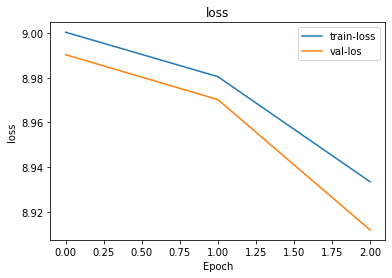

In [28]:
import matplotlib.pyplot as plt

def plot_performance(x, y1, y2, label_1, label_2, label_y):
    plt.plot(x, y1, label = label_1)
    plt.plot(x, y2, label = label_2)
    plt.title('title name')
    plt.xlabel('Epoch')
    plt.ylabel(label_y)
    plt.title(label_y)
    plt.legend()
    plt.show()

    
plot_performance(x=range(3), 
                 y1=model.history.history['loss'], 
                 y2=model.history.history['val_loss'], 
                 label_1='train-loss', 
                 label_2='val-los', 
                 label_y='loss')

In [ ]:
plot_performance(x=range(3), 
                 y1=model.history.history['recall_at_1'], 
                 y2=model.history.history['val_recall_at_1'], 
                 label_1='recall_at_1', 
                 label_2='recall_at_1_val', 
                 label_y='recall_at_1')

#### Save query model

In [53]:
artifact_path = os.path.join(output_path, 'spotify-2t-query-model2')
model.save(artifact_path) #saves keras model

In [54]:
# !pip install google-cloud-aiplatform

### Save embeddings to GCS for each song - this will become our Matching Engine index

In [55]:
from merlin.models.utils.dataset import unique_rows_by_features

item_features = (
    unique_rows_by_features(train, Tags.ITEM, Tags.ITEM_ID)
    .compute()
    .reset_index(drop=True)
)

item_embs = model.item_embeddings(
    MerlinDataset(item_features, schema=schema), batch_size=1024
)
item_embs_df = item_embs.compute(scheduler="synchronous")

In [56]:
item_features

,track_uri_can,artist_name_can,track_name_can,artist_genres_can,duration_ms_can,track_pop_can,artist_pop_can,artist_followers_can
0,1,3,3,9,-0.781673,1.586067,1.230248,0.946740
1,2,1,6,3,-0.822475,-1.214718,1.619445,4.136339
2,3,186,8,194,-0.129093,0.927059,-0.159740,-0.465144
3,4,17,5,23,-0.195589,1.520166,1.230248,2.201993
4,5,12,1,19,0.138343,1.619018,0.896651,0.894903
...,...,...,...,...,...,...,...,...
2183652,2183653,168742,1101982,33697,2.539941,-1.247668,-2.050123,-0.526341
2183653,2183654,3483,1378960,3231,1.432538,-1.280619,-0.159740,-0.491750
2183654,2183655,4155,1073867,7,-0.494134,-1.280619,-0.437737,-0.510225
2183655,2183656,30656,9333,1,0.107287,-1.181768,-1.327330,-0.526103


### Remove other features

In [57]:
drop_cols = schema.select_by_tag([Tags.ITEM]).column_names
drop_cols.remove('track_uri_can')
drop_cols

['artist_name_can',
 'track_name_can',
 'artist_genres_can',
 'duration_ms_can',
 'track_pop_can',
 'artist_pop_can',
 'artist_followers_can']

In [58]:
# select only item_id together with embedding columns
item_embeddings = item_embs_df.drop(
    columns=drop_cols
)

In [59]:
item_embeddings.head()

,track_uri_can,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,1,-134.592117,-127.954391,-133.313034,128.020828,122.533730,-134.170090,127.807892,129.080811,134.454453,...,133.687439,-133.462631,-132.717361,-133.298508,132.301498,-131.986435,136.054092,133.282730,115.622917,127.961784
1,2,-134.547058,-127.970764,-133.234039,128.050339,122.717964,-134.152359,127.813179,129.291458,134.497345,...,133.722412,-133.461105,-132.791519,-133.354340,132.260071,-132.006729,136.030609,133.266617,115.920036,127.985733
2,3,-134.536575,-127.973366,-133.226273,128.040863,122.625320,-134.125000,127.807846,129.279724,134.488632,...,133.727127,-133.514587,-132.796219,-133.375992,132.254272,-131.906021,136.014282,133.223389,115.832359,127.972672
3,4,-134.479004,-127.966591,-133.234482,128.039505,122.597847,-134.093506,127.822105,129.273102,134.456253,...,133.697922,-133.449463,-132.777939,-133.325928,132.254593,-131.954422,136.048096,133.211288,115.812042,127.960014
4,5,-134.471298,-127.979782,-133.191940,128.070923,122.776558,-134.075653,127.806740,129.150970,134.515564,...,133.689575,-133.547531,-132.770218,-133.419815,132.193253,-132.059814,135.955276,133.268005,115.741837,127.971718


Note that these item ids are encoded values, not the raw original values. 

Below, we create the reverse dictionary lookup functionality to be able to map these encoded item ids to their original raw ids - track_uri_can

In [60]:
item_data = pd.read_parquet('categories/unique.track_uri_can.parquet')

# named_embeddings = item_embeddings.to_replace(lambda x: item_data.track_uri_can[x.index])
# named_embeddings
lookup_dict = dict(item_data['track_uri_can'])


item_embeddings_pd = item_embeddings.to_pandas()

named_embeddings = item_embeddings_pd

named_embeddings['track_uri_can'] = named_embeddings['track_uri_can'].apply(lambda l: lookup_dict[l])

named_embeddings

,track_uri_can,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,-134.592117,-127.954391,-133.313034,128.020828,122.533730,-134.170090,127.807892,129.080811,134.454453,...,133.687439,-133.462631,-132.717361,-133.298508,132.301498,-131.986435,136.054092,133.282730,115.622917,127.961784
1,spotify:track:1xznGGDReH1oQq0xzbwXa3,-134.547058,-127.970764,-133.234039,128.050339,122.717964,-134.152359,127.813179,129.291458,134.497345,...,133.722412,-133.461105,-132.791519,-133.354340,132.260071,-132.006729,136.030609,133.266617,115.920036,127.985733
2,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,-134.536575,-127.973366,-133.226273,128.040863,122.625320,-134.125000,127.807846,129.279724,134.488632,...,133.727127,-133.514587,-132.796219,-133.375992,132.254272,-131.906021,136.014282,133.223389,115.832359,127.972672
3,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,-134.479004,-127.966591,-133.234482,128.039505,122.597847,-134.093506,127.822105,129.273102,134.456253,...,133.697922,-133.449463,-132.777939,-133.325928,132.254593,-131.954422,136.048096,133.211288,115.812042,127.960014
4,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,-134.471298,-127.979782,-133.191940,128.070923,122.776558,-134.075653,127.806740,129.150970,134.515564,...,133.689575,-133.547531,-132.770218,-133.419815,132.193253,-132.059814,135.955276,133.268005,115.741837,127.971718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183652,spotify:track:7zzqmTPlaxP5i2JjssL2T6,-134.722977,-127.908379,-133.038620,127.990288,123.086082,-134.232971,127.803520,128.905884,134.532425,...,133.794998,-133.529221,-132.723465,-133.401810,132.183365,-132.012222,136.210907,133.258331,115.375687,128.002792
2183653,spotify:track:7zzrzbrb14URUZlmSrCGfM,-134.371414,-127.866844,-133.252121,128.004013,123.069305,-134.229477,127.833519,129.129593,134.454651,...,133.831177,-133.504379,-132.718582,-133.342026,132.177628,-132.278763,135.797729,133.261887,115.170700,128.009995
2183654,spotify:track:7zzuTn6PnJ1DVfAiGsd4N0,-134.650818,-127.953529,-133.065384,128.016663,121.581764,-134.008286,127.828033,129.333557,134.424911,...,133.742798,-133.493713,-132.657028,-133.293320,132.145935,-132.200211,136.023193,133.193024,115.437462,128.027985
2183655,spotify:track:7zzwsf6tmZETUV26kR7D5z,-134.311172,-127.922691,-133.004410,127.979927,123.464638,-134.195099,127.829185,129.270081,134.630783,...,133.783936,-133.608047,-132.726791,-133.359436,132.217407,-132.324158,136.161758,133.332764,114.744881,128.026138


### Finally, save the embeddings to gcs

In [63]:
named_embeddings.to_json(os.path.join(output_path,'embeddings/song-embeddings.json')) #save the json file to gcs
#embeddings have to saved in a seperate folder where the only file is the jsonl for import to matching engine